In [1]:
import pandas as pd
import numpy as np
from pyperclip import copy

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit, OptimizeWarning
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)

# OBTENÇÃO DOS DADOS
- Objetivo $\Rightarrow$ converter o valor analógico de tensão lido pelo ESP32 para concentração de álcool em mg/L 
- Monovariável $\Rightarrow$ $mgl(analog) = $ ?
- Utilização de curve fit

In [2]:
df = pd.read_csv('DataBase.csv')

print(len(df))
df.head()

77


,sensor_id,analog,mgl,timestamp
0,ETL1317714633862637,22892.0,0.0,2024-06-06 09:11:47
1,ETL4448779365468899,23734.0,0.0,2024-06-06 09:11:47
2,ETL4448779365468899,24170.0,0.0,2024-06-06 09:11:47
3,ETL1317714633862637,22520.0,0.0,2024-06-06 09:11:47
4,ETL6836861188871367,23830.0,0.0,2024-06-06 09:11:47


# PRECISÃO DOS DADOS
- Avaliando um sensor desejado para verificar se os dados estão estáveis e concentrando-se ao redor de uma média central (verificação de outliers)

In [3]:
sensorTarget = 'ETL1317714633862637'
df['sensor_id'].unique().tolist()

['ETL1317714633862637',
 'ETL4448779365468899',
 'ETL6836861188871367',
 'ETL1598212059793199',
 'ETL2524509934905051',
 'ETL4071287399758145',
 'ETL7811811379611562']

In [4]:
def getVariation(data, value=False):
    n = len(data)
    std   = np.std(data, ddof=1)
    value = np.mean(data) if not value else value

    tStudent = [
        12.706, 4.303, 3.182, 2.776, 2.571, 2.447, 2.365, 2.306, 2.262, 2.228,
        2.201, 2.179, 2.160, 2.145, 2.131, 2.120, 2.110, 2.101, 2.093, 2.086,
        2.080, 2.074, 2.069, 2.064, 2.060, 2.056, 2.052, 2.048, 2.045, 2.042
    ]

    if n <= 30:
        return (tStudent[n-2] * std / np.sqrt(n)) / value * 100
    
    return (std / np.sqrt(n)) / value * 100


def getFitPrecision(df, sensorTarget):
    df   = df.loc[df['sensor_id'] == sensorTarget]
    data = []

    for mgl in df['mgl'].unique():
        sample = {}
        target = df.loc[df['mgl'] == mgl]
        relative = getVariation(target.analog)
        
        sample['mgl']  = round(mgl, 4)
        sample['size'] = len(target)
        sample['relative'] = round(relative, 3)
        data.append(sample)

    return data


data = getFitPrecision(df, sensorTarget)
print(sensorTarget)

for sample in data:
    print(f'mgl = {sample['mgl']} | {sample['size']} dados | incerteza = {sample['relative']}%')

ETL1317714633862637
mgl = 0.0 | 2 dados | incerteza = 10.408%
mgl = 0.0952 | 3 dados | incerteza = 2.549%
mgl = 0.2381 | 3 dados | incerteza = 7.351%
mgl = 0.4762 | 3 dados | incerteza = 3.797%


# ELIMINANDO OUTLIERS

In [5]:
target = df.loc[df['sensor_id'] == sensorTarget]
target.head()

,sensor_id,analog,mgl,timestamp
0,ETL1317714633862637,22892.0,0.000000,2024-06-06 09:11:47
3,ETL1317714633862637,22520.0,0.000000,2024-06-06 09:11:47
14,ETL1317714633862637,16119.0,0.095238,2024-06-06 11:17:26
21,ETL1317714633862637,16442.0,0.095238,2024-06-06 11:17:26
30,ETL1317714633862637,16356.0,0.095238,2024-06-06 11:17:26


In [6]:
def getOutliers(target, mgl, irLimit=10):
    outliers = []

    mglTarget = target.loc[target['mgl'] == mgl]    
    data = mglTarget['analog']
    
    for analog in data:
        ir = getVariation(data, analog)
        
        if ir > irLimit:
            outliers.append({'analog': analog, 'mgl': mgl, 'incerteza': ir})
    
    return outliers


outliers = []

for mgl in target['mgl'].unique():
    newOutliers = getOutliers(target, mgl, 5)
    outliers.extend(newOutliers)

if len(outliers) > 0:
    display(pd.DataFrame(outliers).sort_values(by='incerteza', axis='rows'))

,analog,mgl,incerteza
2,12195.0,0.238095,7.109108
3,11616.0,0.238095,7.463462
4,11568.0,0.238095,7.494431
0,22892.0,0.000000,10.323764
1,22520.0,0.000000,10.494298


In [7]:
#for outlier in outliers: df = df.loc[df['analog'] != outlier['analog']]
getFitPrecision(df, sensorTarget)

[{'mgl': 0.0, 'size': 2, 'relative': 10.408},
 {'mgl': 0.0952, 'size': 3, 'relative': 2.549},
 {'mgl': 0.2381, 'size': 3, 'relative': 7.351},
 {'mgl': 0.4762, 'size': 3, 'relative': 3.797}]

# MODELO - CURVE FIT
- Encontrando a partir dos dados de "analog" a função $mgl = f(analog)$ 
- A função genérica escolhida foi $f(x) = a\cdot b ^{\,c\,x + d}$

In [8]:
def function(x, a, b, c, d):
    return a*b**(c*x + d)

def curveFit(xData, yData, maxIter=2100000000):
    coefs = curve_fit(function, xData, yData, maxfev=maxIter)
    return [round(coef, 12) for coef in list(coefs[0])]

def getFitPrecision(xData, yData, coefs):
    residuals = yData - function(xData, *coefs)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((yData - np.mean(yData))**2)
    prec = 1 - (ss_res / ss_tot)
    return 0 if prec < 0 else prec
    
def getGraph(sensorID):
    target = df.loc[df.sensor_id == sensorID]
    xData, yData = target.analog.values, target.mgl.values

    coefs = curveFit(xData, yData)
    prec  = getFitPrecision(xData, yData, coefs)
    return xData, yData, coefs, prec

In [9]:
target = df.loc[df.sensor_id == sensorTarget]
xData, yData = target.analog.values, target.mgl.values

coefs = curveFit(xData, yData)
prec  = getFitPrecision(xData, yData, coefs)

print('COEFICIENTES: ', coefs)
print(f'CONFIABILIDADE: {prec*100:.6f}%')

COEFICIENTES:  [8.189069160367, 0.999924069923, 3.849145182965, 0.975906796655]
CONFIABILIDADE: 98.118543%


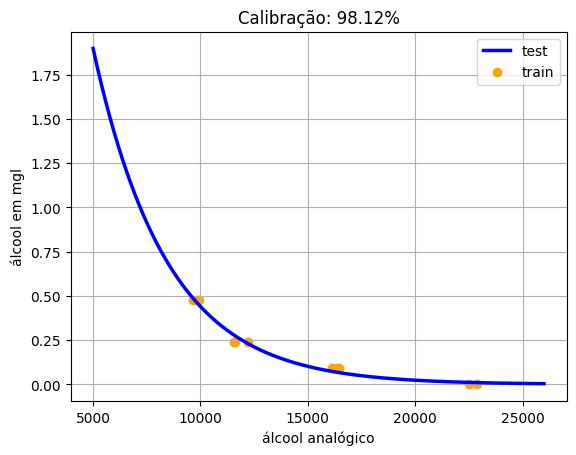

In [10]:
xData, yData, coef, prec = getGraph(sensorTarget)
xTest = np.linspace(5000, 26000, 100000)
yTest = function(xTest, *coef)
plt.plot(xTest, yTest, color='blue', linewidth=2.5, label='test')

plt.scatter(xData, yData, color='orange', label='train')
plt.title(f'Calibração: {prec*100:.2f}%')
plt.xlabel('álcool analógico')
plt.ylabel('álcool em mgl')
plt.legend()
plt.grid()

- Encontrando o valor analógico de "sem álcool", ou seja, onde a concentração é zero 

In [11]:
zero = target.loc[target.mgl == 0].analog.mean()
zero

22706.0

- Testando a tensão em valores aleatórios

In [14]:
function(zero, *coefs)

0.010740698821128991

# TESTANDO EM TODOS

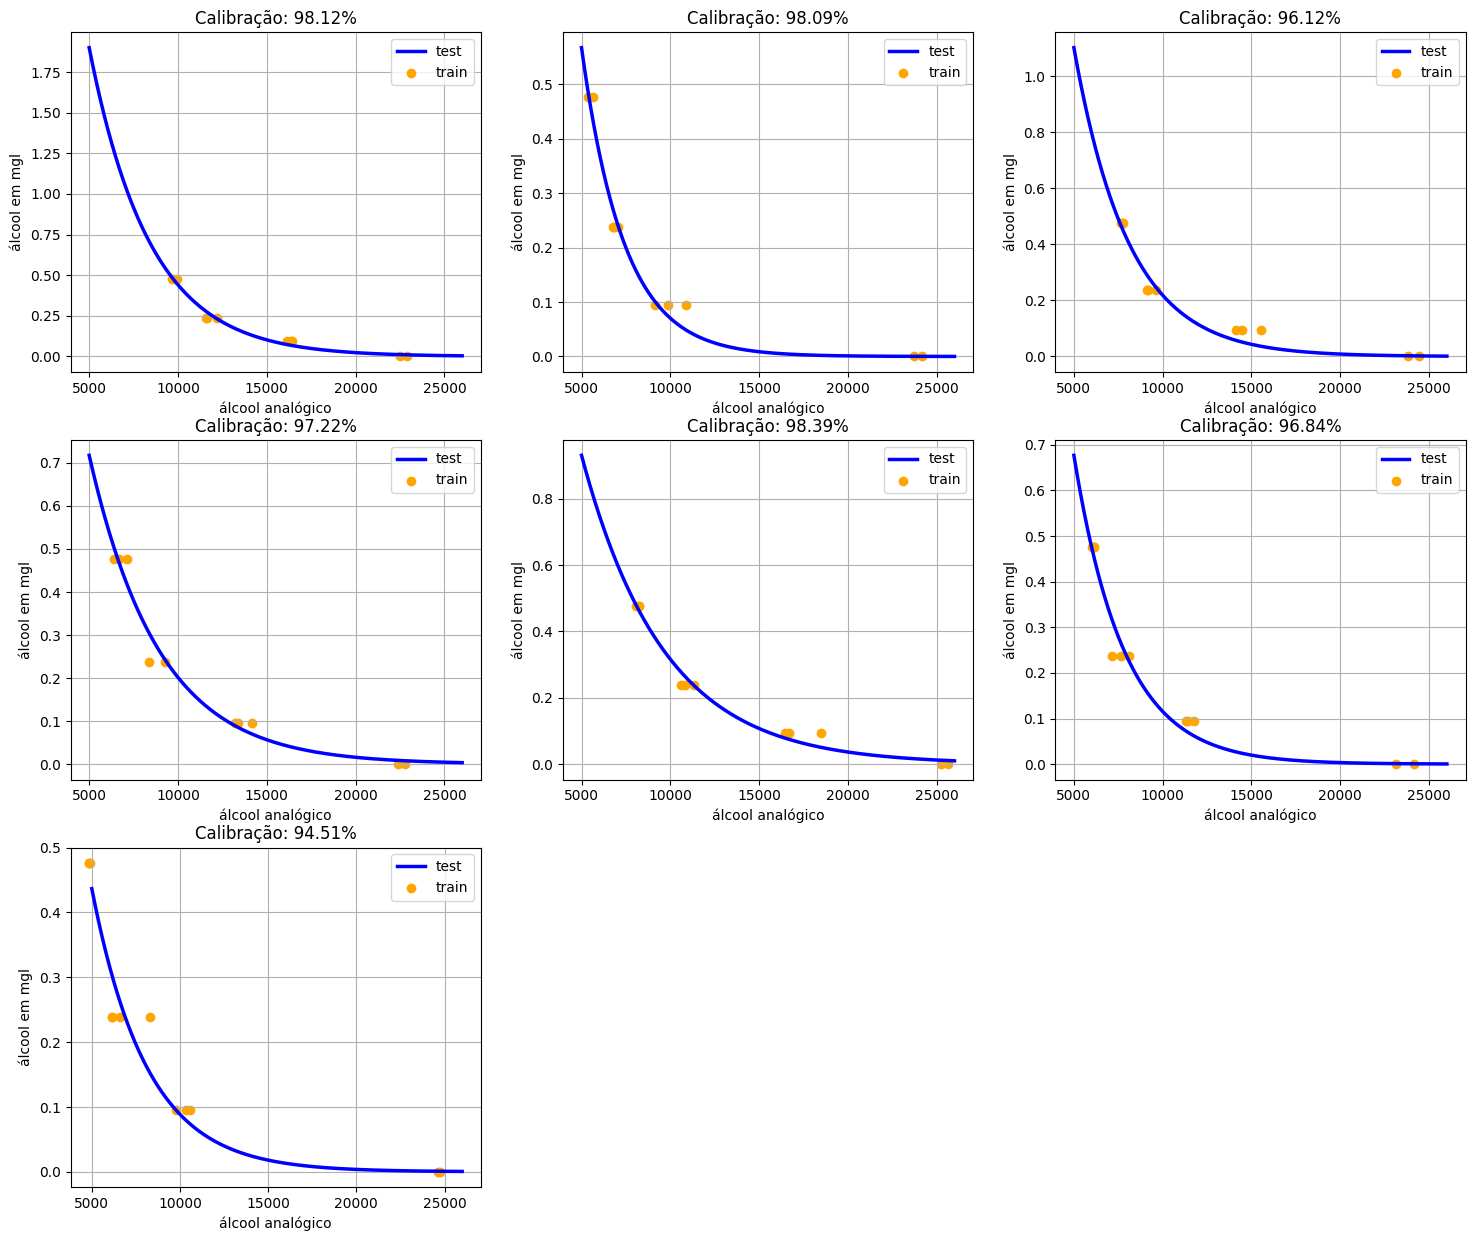

In [13]:
sensors = df['sensor_id'].unique()
numRows = len(sensors) // 3 + 1
plt.figure(figsize=(18, 5*numRows))

for i, sensor in enumerate(sensors):
    plt.subplot(numRows, 3, i+1)
    
    xData, yData, coef, prec = getGraph(sensor)
    xTest = np.linspace(5000, 26000, 100000)
    yTest = function(xTest, *coef)
    plt.plot(xTest, yTest, color='blue', linewidth=2.5, label='test')

    plt.scatter(xData, yData, color='orange', label='train')
    plt.title(f'Calibração: {prec*100:.2f}%')
    plt.xlabel('álcool analógico')
    plt.ylabel('álcool em mgl')
    plt.legend()
    plt.grid()

plt.show()